# Computational analysis of spatial transcriptomics data
## BrainOmics 2.0 - Day 3

#### 20th November 2024
#### Ahmed Mahfouz, Benedetta Manzato (LUMC) 

### Agenda:
<font size="3">1. Spatial data download and format

<font size="3">2. Spatial imputation with SpaGE and Tangram

<font size="3">3. Spatial clustering with BANKSY

<font size="3">4. Access image in AnnData object

# Dataset: MERFISH spatial transcriptomics dataset of a single adult mouse brain (Zhuang-ABCA-1) (Xiaowei Zhuang)

<font size="3"> This spatially resolved cell atlas of the whole mouse brain provides a systematic characterization of the spatial organization of transcriptomically defined cell types across the entire adult mouses brain using in situ, single-cell transcriptomic profiling with multiplexed error-robust fluorescence in situ hybridization (MERFISH). A gene panel of 1,122 genes was imaged in 9 million brain cells using **MERFISH**, and spatially resolved, single-cell expression profiling was performed at the whole-transcriptome scale by integrating the MERFISH data with the whole-brain single-cell RNA-sequencing (scRNA-seq) dataset previously generated by the Allen Institute. This resulted in the generation of a comprehensive cell atlas of more than 5,000 transcriptionally distinct cell clusters, belonging to ∼300 major cell types (subclasses), across the whole mouse brain, with high molecular and spatial resolution.
The authors performed MERFISH imaging on **245 coronal and sagittal sections**, the cell atlas was then spatially registered to the Allen Mouse Brain Common Coordinate Framework (CCFv3), which allows systematic quantifications of the cell composition and organization in individual brain regions as anatomically delineated in the CCFv3. This cell atlas also reveals molecularly-defined brain regions characterized by distinct cell type compositions, spatial gradients featuring gradual changes in the gene-expression profiles of cells, as well as cell-type-specific cell-cell interactions and the molecular basis and functional implications of these cell-cell interactions.

<font size="3"> The collection spans four mouse specimens (two coronal sets and two sagittal sets):
- <font size="3">**Zhuang-ABCA-1**: 
  - **Dataset size**: 4.2 million cells spanning 147 coronal sections with a 1,122 gene panel.
  - **Filtered dataset**: 2.8 million cells passed the cell classification confidence score threshold and are displayed in the ABC atlas.
  
- <font size="3">**Zhuang-ABCA-2**: 
  - **Dataset size**: 1.9 million cells spanning 66 coronal sections.
  - **Filtered dataset**: 1.2 million cells passed the cell classification confidence score threshold.
  
- <font size="3">**Zhuang-ABCA-3**: 
  - **Dataset size**: 2.1 million cells spanning 23 sagittal sections.
  - **Filtered dataset**: 1.6 million cells passed the confidence score threshold.

- <font size="3">**Zhuang-ABCA-4**: 
  - **Dataset size**: 0.22 million cells spanning 3 sagittal sections.
  - **Filtered dataset**: 0.16 million cells passed the confidence score threshold.


<font size="3"> We will work with the Brain Coronal 1 collection (Zhuang-ABCA-1); the cell-by-gene matrix of the 8.4 millions cells can be downloaded from the AWS bucket of this animal. The cells are then filtered by cell-classification (label transfer) confidence scores calculated during MERFISH-scRNAseq data integration. 7.0 million cells passed the confidence score threshold for cell subclass label transfer and 5.8 million cells further passed the confidence score threshold for cell cluster label transfer. These 5.8 million cells are included in the cell metadata file that can be downloaded from the the AWS bucket and are displayed on the ABC Atlas. The CCF coordinates of the 5.4 million cells that were registered to the 3D Allen-CCF can be downloaded from the CCF coordinate files in the AWB bucket. The collection spans four mouse specimens (2 coronal sets and 2 sagittal sets). Cells are mapped to the whole mouse brain taxonomy (WMB-taxonomy) and Allen Common Coordinate Framework (Allen-CCF-2020). 
Refer to Zhang et al, 2023 for more details.


For more details: [Molecularly defined and spatially resolved cell atlas of the whole mouse brain (Zhang et al. 2023)](https://www.nature.com/articles/s41586-023-06808-9)

From https://github.com/AllenInstitute/abc_atlas_access/blob/main/notebooks/zhuang_merfish_tutorial.ipynb

Data Availablity : https://knowledge.brain-map.org/data/5C0201JSVE04WY6DMVC/collections </font>

In [1]:
import time

# Record the start time
start_time = time.time()

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Importing necessary libraries for spatial data analysis and visualization
import os, re
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import anndata as ad

# Display the version of important packages for reproducibility
sc.logging.print_header()

# Set the default aesthetics for Scanpy plots
sc.set_figure_params(facecolor='white', figsize=(8, 8))  # White background, figure size 8x8
sc.settings.verbosity = 0  # Set verbosity to show only errors (0) # errors (0), warnings (1), info (2), hints (3)


KeyboardInterrupt



In [ ]:
# Importing functions to handle file paths and download data from ABC Atlas
from pathlib import Path  # Object-oriented file paths
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache  # Cache system for ABC Atlas data

<font size="3"> We create an output folder in your local space to save outputs:

In [ ]:
folder_path = './outputs/'
if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder created: {folder_path}")
else:
    print(f"Folder already exists: {folder_path}")

In [ ]:
spatial_wd = '/group/brainomics/InputData'

<font size="3">We will use [AbcProjectCache](https://github.com/AllenInstitute/abc_atlas_access/tree/41eb836e41e516ee528c98bf3979d0aff60c0b85) to download the data required for the tutorials.</font>

<font size="3">Data associated with the Allen Brain Cell Atlas is hosted on Amazon Web Services (AWS) in an S3 bucket as a AWS Public Dataset. No account or login is required. The S3 bucket is located here arn:aws:s3:::allen-brain-cell-atlas. You will need to be connected to the internet to run this notebook.

<font size="3">Each data release has an associated manifest.json which lists all the specific version of directories and files that are part of the release.</font>

In [ ]:
# Define the base path where data will be downloaded
#download_base = Path('./outputs/abc_download_root')  # Path to save downloaded data
download_base = Path('/exports/humgen/bmanzato/abc_download_root')  # Path to save downloaded data

# Initialize the ABC Project Cache to manage downloaded data from the ABC Atlas
abc_cache = AbcProjectCache.from_s3_cache(download_base)  # Fetch data from S3 cache

# abc_cache.current_manifest show the current cache manifest
abc_cache.current_manifest

In [ ]:
abc_cache.load_latest_manifest()

# List available directories
abc_cache.list_directories

<font size="3">We will use the **Zhuang-ABCA-1 dataset**: 4.2 million cell spatial transcriptomics dataset spanning 147 coronal sections with a 1122 gene panel. 2.8 million cells passed cell classification confidence score threshold and displayed in the ABC atlas

<font size="3">List data files available in the Zhuang-ABCA-1 directory:

In [ ]:
abc_cache.list_data_files('Zhuang-ABCA-1')

<font size="3">List metadata files available in the Zhuang-ABCA-1 directory:

In [ ]:
abc_cache.list_metadata_files('Zhuang-ABCA-1')

<font size="3">Check the size of data and metadata:

In [ ]:
print(f"Size of data: {abc_cache.get_directory_data_size('Zhuang-ABCA-1')}")

<font size="3">Obtain path of data and metadata:

```python
path_data = abc_cache.get_directory_data('Zhuang-ABCA-1')
print("Zhuang-ABCA-1 data files:\n\t", path_data)

```python
path_metadata = abc_cache.get_directory_metadata('Zhuang-ABCA-1')
print("Zhuang-ABCA-1 metadata files:\n\t", path_metadata)

<font size="3">We previously downloaded the data for you, you can find them in `abc_download_root/`

### Data format

<font size="3"> Expression matrices are stored in the [anndata h5ad format](https://anndata.readthedocs.io/en/latest/) and need to be downloaded to a local file system for usage.

<font size="3">**Key Components of an AnnData Object:**

<font size="3">- **`.X`**: The main data matrix (usually cells by genes), where the rows are cells and the columns are genes. It typically stores raw or normalized gene expression data.

<font size="3">- **`.obs`**: Observations (metadata about the cells), such as cell type, experimental conditions, or quality control metrics.

<font size="3">- **`.var`**: Variables (metadata about the genes), such as gene names or other annotations.

<font size="3">- **`.obsm`**: Multi-dimensional annotations of cells, such as dimensionality reduction results (e.g., PCA, UMAP coordinates).

<font size="3">- **`.uns`**: Unstructured annotations, typically storing experimental metadata or plot settings.

<font size="3">- **`.layers`**: Stores multiple versions of the data matrix (e.g., raw counts, normalized data, etc.).

<figure>
    <img src="img/anndata_format.png" alt="AnnData format" width="500" alt="Description of the image">
    <figcaption>From <a href="https://joss.theoj.org/papers/10.21105/joss.04371" target="_blank">Virshup et al. (2024) JOSS</a></figcaption>
</figure>


<font size="3">Spatial coordinates, being metadata about cells/spots are stored either in **`.obs`** or **`.obsm`**

<span style="color: red; font-size: 15px;"> **Read raw count AnnData object first:**

In [ ]:
## EX 1
### Hint: use the function ad.read_h5ad 

path_raw_adata = f"{spatial_wd}/day3/abc_download_root/expression_matrices/Zhuang-ABCA-1/Zhuang-ABCA-1-raw.h5ad"

# don't change the variable name
adata = 

<span style="color: red; font-size: 15px;"> **Now read log-transformed AnnData object**

In [ ]:
## EX 2
### Hint: use the function ad.read_h5ad 

path_log_adata = f"{spatial_wd}/day3/abc_download_root/expression_matrices/Zhuang-ABCA-1/Zhuang-ABCA-1-log2.h5ad"

# don't change the variable name
adata_log = 

<font size="3">Now we need to add the log-transformed data to the `adata` object

<span style="color: red; font-size: 15px;"> **To which component should it be added to?**

In [ ]:
## EX 3
# Add the log-transformed counts to the 'log' layer and the count data to the 'raw' layer
### Hint: what slot of the adata object is suitable for count matrices?



<font size="3">We delete adata_log since it won't be used anymore:

In [ ]:
del adata_log

<span style="color: red; font-size: 15px;"> **Read metadata:**

In [ ]:
## EX 4
# Read genes
### Hint: use the function pd.read_csv and keep the gene identifier as index
path_metadata_genes = f"{spatial_wd}/day3/abc_download_root/metadata/Zhuang-ABCA-1/gene.csv"

genes = 
genes.head()

In [ ]:
## EX 5
# Read cells
### Hint: use the function pd.read_csv and keep the cell label as index
path_metadata_cell = f"{spatial_wd}/day3/abc_download_root/metadata/Zhuang-ABCA-1/views/cell_metadata_with_cluster_annotation.csv"

cell_metadata_extended = 
cell_metadata_extended.head()

 <span style="color: red; font-size: 15px;"> **Add gene names to the right component in the `adata` object**

In [ ]:
## EX 6
## Where should we store the gene metadata?


<font size="3">Let's show some stats about the dataset:

In [ ]:
print(f"Number of sections in the dataset: {len(cell_metadata_extended['brain_section_label'].unique())}")
print(f"Total number of cells/spots in the dataset: {cell_metadata_extended.shape[0]}")
print(f"Average number of cells/spots per section: {cell_metadata_extended.shape[0] / len(cell_metadata_extended['brain_section_label'].unique())}")
print(f"Size of the gene panel: {adata.shape[1]}")

<font size="3">We decided to work with **one section only**; let's select the one that captures most cells


<img src="img/ABCAtlas_Zhuang-ABCA-1_Coronal Grid.png" width="800" height="300">

<span style="color: red; font-size: 15px;"> **Which section has captures the highest number of cells?**

In [ ]:
## EX 7
### Hint : use collections.Counter - https://docs.python.org/3/library/collections.html#collections.Counter
import collections

### Steps: 
# 1. Identify the brain_section_label of the section with the highest number of cells
# 2. Subset cell_metadata_extended and adata to include only cells from that section



<font size="3">Let's inspect `adata_section` and `cell_metadata_extended_sub`

In [ ]:
adata_section.obs.head()

In [ ]:
cell_metadata_extended_sub.head()

<font size="3"> We notice that the indexes don't match! It's important to reorder the indexes in cell_metadata_extended_sub to match the ones in adata_section.obs:

In [ ]:
cell_metadata_extended_sub_reind = cell_metadata_extended_sub.reindex(adata_section.obs.index)

In [ ]:
collections.Counter(cell_metadata_extended_sub_reind.index == adata_section.obs.index)

<font size="3">Now we can add cell_metadata_extended_sub as metadata to adata_section

In [ ]:
adata_section.obs = cell_metadata_extended_sub_reind

<font size="3">Plot the section and color them by all the different classifications avaiable in the metadata (class_color, subclass_color, supertype_color, cluster_color):

In [ ]:
# Create the color mapping dictionaries
class_palette = dict(zip(adata_section.obs['class'].unique(), adata_section.obs['class_color'].unique()))
subclass_palette = dict(zip(adata_section.obs['subclass'].unique(), adata_section.obs['subclass_color'].unique()))
supertype_palette = dict(zip(adata_section.obs['supertype'].unique(), adata_section.obs['supertype_color'].unique()))
cluster_palette = dict(zip(adata_section.obs['cluster'].unique(), adata_section.obs['cluster_color'].unique()))

# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Scatter Plots of Different Categories', fontsize=16)

# Plot 'class' using class_color
sns.scatterplot(ax=axes[0, 0], x='x', y=-adata_section.obs['y'], hue='class', palette=class_palette, data=adata_section.obs, s=8, legend=False)
axes[0, 0].set_title('Class')
axes[0, 0].set_xlabel('X Coordinate')
axes[0, 0].set_ylabel('Y Coordinate')
axes[0, 0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[0, 0].grid(False)  # Remove grid

# Plot 'subclass' using subclass_color
sns.scatterplot(ax=axes[0, 1], x='x', y=-adata_section.obs['y'], hue='subclass', palette=subclass_palette, data=adata_section.obs, s=8, legend=False)
axes[0, 1].set_title('Subclass')
axes[0, 1].set_xlabel('X Coordinate')
axes[0, 1].set_ylabel('Y Coordinate')
axes[0, 1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[0, 1].grid(False)  # Remove grid

# Plot 'supertype' using supertype_color
sns.scatterplot(ax=axes[1, 0], x='x', y=-adata_section.obs['y'], hue='supertype', palette=supertype_palette, data=adata_section.obs, s=8, legend=False)
axes[1, 0].set_title('Supertype')
axes[1, 0].set_xlabel('X Coordinate')
axes[1, 0].set_ylabel('Y Coordinate')
axes[1, 0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[1, 0].grid(False)  # Remove grid

# Plot 'cluster' using cluster_color
sns.scatterplot(ax=axes[1, 1], x='x', y=-adata_section.obs['y'], hue='cluster', palette=cluster_palette, data=adata_section.obs, s=8, legend=False)
axes[1, 1].set_title('Cluster')
axes[1, 1].set_xlabel('X Coordinate')
axes[1, 1].set_ylabel('Y Coordinate')
axes[1, 1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
axes[1, 1].grid(False)  # Remove grid

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


### Quality Control

<font size="3">From https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html

In [ ]:
# make gene names unique
adata_section.var_names_make_unique()
# add mt percentage
adata_section.var["mt"] = adata_section.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata_section, qc_vars=["mt"], inplace=True)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(adata_section.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata_section.obs["total_counts"][adata_section.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)

#### Cell Filtering and Preprocessing in Single-Cell RNA-Seq Analysis

<font size="3">In this section, we are performing a series of filtering steps to preprocess the single-cell RNA sequencing (scRNA-seq) data stored in the `adata_section` object. The filtering aims to retain high-quality cells and genes for downstream analyses. The following steps are applied:

1. <font size="3">**Filter Cells by Minimum Counts**: 
   - <font size="3">We filter out cells that have fewer than 200 counts. This helps to exclude low-quality cells that may not provide reliable information.

In [ ]:
sc.pp.filter_cells(adata_section, min_counts=200)

2. <font size="3">**Filter Cells by Maximum Counts**: 
   - <font size="3">We also filter out cells with more than 25,000 counts to remove potential doublets or outlier cells that may artificially inflate the count data

In [ ]:
sc.pp.filter_cells(adata_section, max_counts=25000)

3. <font size="3">**Filter Based on Mitochondrial Gene Expression**:

   - <font size="3">We further refine our dataset by excluding cells that have more than 10% of their total counts coming from mitochondrial genes.

In [ ]:
adata_section = adata_section[adata_section.obs["pct_counts_mt"] < 10].copy()

4. <font size="3">**Filter Genes by Minimum Cells**:

- <font size="3">Finally, we filter out genes that are detected in fewer than 20 cells, ensuring that we retain only those genes that have sufficient expression across our dataset.

<span style="color: red; font-size: 15px;"> **Filter out genes that are detected in less than 20 cells**

In [ ]:
## EX 8
### Hint: use sc.pp.filter_genes


In [ ]:
print(f"Number of cells after filtering: {adata_section.n_obs}")

<font size="3"> Perform PCA and UMAP and cluster with Leiden Algorithm

In [ ]:
sc.pp.pca(adata_section)
sc.pp.neighbors(adata_section)
sc.tl.umap(adata_section)
sc.tl.leiden(
    adata_section, 
    key_added="clusters", 
    resolution=1.0,
    directed=False, 
    n_iterations=2
)

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)
sc.pl.umap(adata_section, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.2)

<font size="3"> Some stats:

In [ ]:
print('Number of Neurotransmitters: ', len(adata_section.obs['neurotransmitter'].unique()))
print('Number of Classes: ', len(adata_section.obs['class'].unique()))
print('Number of Subclasses: ', len(adata_section.obs['subclass'].unique()))
print('Number of Supertype: ', len(adata_section.obs['supertype'].unique()))
print('Number of Cluster: ', len(adata_section.obs['cluster'].unique()))

<font size="3"> The filtering step performed by the authors of the paper is done differently than the basic one we just performed. The metadata is given only for the filtered object. For this reason we will filter our object to keep only spots that passed the quality control for the Allen Brain Atlas standards.

In [ ]:
# filter spots in adata_section and keep only the ones that are present in metadata
adata_section = adata[adata.obs.index.isin(cell_metadata_extended_sub.index)]
# reindex cell_metadata_ext_sub to match the index order of adata_section.obs
cell_metadata_extended_sub = cell_metadata_extended_sub.reindex(adata_section.obs.index)
# add metadata to the metadata field in an anndata object : adata.obj
adata_section.obs = cell_metadata_extended_sub

print(f"The filtered Section 80 dataset has {adata_section.shape[0]} cells and {adata_section.shape[1]} genes.")

<font size="3"> To free RAM, we delete the `adata` object as we will use only the section:

In [ ]:
del adata

<font size="3"> Some spatial tools require the spatial coordinates can be stored as `spatial` or `X_spatial`

In [ ]:
## EX 9
# Add X_spatial to the right field
x_spatial = np.array(adata_section.obs[['x','y']])



<font size="3"> Once the spatial coordinates are stored in  `.obsm[X_spatial]` you can plot the section with `sc.pl.spatial`


In [ ]:
# Generate the spatial plot
sc.pl.spatial(adata_section, color='class', color_map='Accent_r', spot_size=0.04, title='Section 80 colored by Class')

In [ ]:
## EX 10
# Subset the AnnData object to keep only cells belonging to a specific class
# and plot them again with sc.pl.spatial
adata_section_one_class = 
sc.pl.spatial(..)

### Plot gene expression in space

<font size="3">

Since each spot in the spatial data corresponds to a specific location and its associated gene expression profile, we can visualize spatial gene expression.

We can do this using the function `sc.pl.spatial`, it requires the name of the variable index to indicate the genes to plot.

Let's take a look at `adata_section`.var:

In [ ]:
adata_section.var.head()

<font size="3">

Change the index of the `adata_section.var` to `gene_symbol` for clarity

In [ ]:
# Reset the index to turn the current index into a column
adata_section.var.reset_index(inplace=True)
adata_section.var.set_index('gene_symbol', inplace=True)
adata_section.var.head()

In [ ]:
# Define genes to plot
genes_toplot = ['Zic1',
 'Penk',
 'Gfap',
 'Dlx6',
 'Cux2',
 'Fezf2',
 'Nr4a2',
 'Satb2']

sc.pl.spatial(adata_section, color=genes_toplot,spot_size=0.04)

<span style="color: red; font-size: 15px;"> **Plot your favourite gene/s**

In [ ]:
#genes_toplot = [.....]

#sc.pl.spatial(adata_section, color=genes_toplot,spot_size=0.04)

In [ ]:
adata_section.write_h5ad(f"./outputs/adata_section80.h5ad")

In [ ]:
# Record the end time
end_time = time.time()

# Calculate elapsed time in minutes
elapsed_time = (end_time - start_time) / 60
print(f"Execution Time: {elapsed_time:.2f} minutes")

# Prediction of spatial patterns for unmeasured genes using scRNA-seq data with SpaGE

In [ ]:
start_time = time.time()

In [ ]:
from SpaGE.main import SpaGE
import scipy.stats as st

<figure>
    <img src="img/spage.jpg" width="700" height="280" alt="Description of the image">
    <figcaption>From <a href="https://academic.oup.com/nar/article/48/18/e107/5909530" target="_blank">Abdelaal et al. (2020) NAR</a></figcaption>
</figure>

<font size="3"> SpaGE takes as input the (targeted) spatial dataset (query) and a single-cell RNA dataset used as reference. The two datasets should be generated under the same conditions (same species, tissue, region) as much as possible.

<font size="3"> We will use [Mouse whole-brain transcriptomic cell type atlas (Hongkui Zeng)](https://www.nature.com/articles/s41586-023-06812-z).This scRNAseq dataset profiled 7 million cells (approximately 4.0 million cells passing quality control). More in detail:

 - <font size="3"> 1.7 million single cell transcriptomes spanning the whole adult mouse brain using 10Xv2 chemistry (WMB-10Xv2)

 - <font size="3"> 2.3 million single cell transcriptomes spanning the whole adult mouse brain using 10Xv3 chemistry (WMB-10Xv3)

 - <font size="3"> 1687 single cell transcriptomes spanning the whole adult mouse brain using the 10X Multiome chemistry (WMB-10XMulti)

<figure>
    <img src="img/sc.png" width="700" height="280" alt="Description of the image">
    <figcaption>From <a href="https://www.nature.com/articles/s41586-023-06812-z" target="_blank">Yao et al. (2023) Nature Methods</a></figcaption>
</figure>



<font size="3"> Let's check the names of the files in each of the three single-cell collections:

In [ ]:
abc_cache.list_data_files('WMB-10Xv2')

In [ ]:
abc_cache.list_data_files('WMB-10Xv3')

In [ ]:
abc_cache.list_data_files('WMB-10XMulti')

<font size="3"> Let's check the size of the files in each of the three single-cell collections:

In [ ]:
print(f"Size of WMB-10Xv2 data: {abc_cache.get_directory_data_size('WMB-10Xv2')}")

In [ ]:
print(f"Size of WMB-10Xv3 data: {abc_cache.get_directory_data_size('WMB-10Xv3')}")

In [ ]:
print(f"Size of WMB-10X Multi data: {abc_cache.get_directory_data_size('WMB-10XMulti')}")

<font size="3"> The size is of the combined single-cell object is around 280GB. For this reason, the three objects have been previously downloaded, concatenated, preprocessed and subsetted to obtain NNN cells. For your knowledge, you can find all the steps in `obtain_scref.py`.

<font size="3"> Let's read the resulting single-cell AnnData object:

In [ ]:
adata_sc = ad.read_h5ad(f"{spatial_wd}/day3/SpaGE_data/sc_adata_1percent.h5ad")

<font size="3"> Inspect the object:

In [ ]:
adata_sc

<font size="3"> Inspect the metadata:

In [ ]:
adata_sc.obs.head()

<font size="3"> Add feature metadata to the AnnData object

In [ ]:
genes = pd.read_csv(f"{spatial_wd}/day3/abc_download_root/metadata/WMB-10X/gene.csv",index_col=0)

genes.head()

In [ ]:
adata_sc.var = genes

In [ ]:
# Reset the index to turn the current index into a column
adata_sc.var.reset_index(inplace=True)
adata_sc.var.set_index('gene_symbol', inplace=True)
adata_sc.var.head()

<font size="3"> Set up inputs for SpaGE:

In [ ]:
# Extract the count data and transform them into a Pandas DataFrame
RNA_data = pd.DataFrame(adata_sc.X.todense())

In [ ]:
# Add gene names to the RNA_data columns 
RNA_data.columns = adata_sc.var.index

In [ ]:
# Filter lowely expressed genes
Genes_count = np.sum(RNA_data > 0, axis=1)
RNA_data = RNA_data.loc[Genes_count >=10,:]
del Genes_count

In [ ]:
# Normalization
def Log_Norm_cpm(x):
    return np.log(((x/np.sum(x))*1000000) + 1)
RNA_data = RNA_data.apply(Log_Norm_cpm,axis=0)

In [ ]:
# transpose RNA_data to have rows = genes and columns = cells
RNA_data = RNA_data.T

In [ ]:
RNA_data.head()

In [ ]:
# Drop any row with at least one NaN value
RNA_data = RNA_data.dropna()  # This will drop any row with at least one NaN value

<span style="color: red; font-size: 15px;"> **How many genes do the spatial and single-cell data set have in common?**

<span style="color: red; font-size: 15px;"> **How many genes are measured in the single-cell dataset that are not measured in the spatial dataset?**

In [ ]:
## EX 11
## Hint: use .intersection


## Hint: use a set operation


print(f"Number of genes measured both in the sc and spatial datasets: {len(gene_intersection)}")
print(f"Number of genes measured in the sc reference only: {len(genes_not_intersection)}")

In [ ]:
# Extract count matrix from adata_section and rename index and column names

spatial_data = pd.DataFrame(adata_section.X)
spatial_data.index = adata_section.obs.index
spatial_data.columns = adata_section.var.index

In [ ]:
# Normalize spatial_data 
spatial_data = spatial_data.apply(Log_Norm_cpm,axis=0)

In [ ]:
brain_region_specific_genes = [
    "Bcl11b", "Cux2", "Fezf2", "Tbr1", "Satb2", # isocortex
    "Foxp2",  # Striatum specific
    "Penk",   # Basal ganglia specific
    "Zic1",   # Cerebellum specific
    "Hoxb2",  # Hindbrain specific
    "Dlx6",   # Subpallium specific
]

# Checking for genes from brain_region_specific_genes that are measured by spatial data
overlap_genes = list(set(list(spatial_data.columns)) & set(brain_region_specific_genes))
overlap_genes

In [ ]:
# Checking for genes from brain_region_specific_genes that are NOT measured by spatial data
non_overlap_genes = list(set(brain_region_specific_genes) - set(overlap_genes))

### Leave-one-gene-out cross validation

<font size="3"> Define the function to predict genes measured in the spatial dataset to have a ground truth and plot the measured expression next to the predicted one.
<font size="3"> Calculate Spearman correlation between the measured and predicted expression.

In [ ]:
import matplotlib.gridspec as gridspec  # Import for more precise subplot layout control
plt.style.use('dark_background')

def plot_measured_predicted(Gene_set, corr_df):

    for i in Gene_set:
        # Predict the expression of the current gene using the SpaGE method
        Imp_Genes = SpaGE(spatial_data.drop(i, axis=1), RNA_data.T, n_pv=30, genes_to_predict=[i])
    
        # Calculate the Spearman correlation between measured and predicted values
        corr_df[i] = st.spearmanr(spatial_data[i], Imp_Genes[i])[0]
    
        # Create a figure with two subplots (1 row, 2 columns)
        fig = plt.figure(figsize=(15, 8))  # Adjust figure size if needed
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)  # Create a gridspec for better control
    
        # --- Measured Gene Expression Plot ---
        ax0 = fig.add_subplot(gs[0])  # First plot
        cmap_measured = spatial_data[i]
        cmap_measured[cmap_measured > np.percentile(cmap_measured, 99)] = np.percentile(cmap_measured, 99)
        sc1 = ax0.scatter(adata_section.obs['x'], -adata_section.obs['y'], s=1, c=cmap_measured, alpha=1)
    
        ax0.set_title(f'Measured Expression: {i}', fontsize=12)
        ax0.set_xlabel('X coordinate')
        ax0.set_ylabel('Y coordinate')
        ax0.set_aspect('equal', adjustable='box')
        ax0.grid(False)
    
        # --- Predicted Gene Expression Plot ---
        ax1 = fig.add_subplot(gs[1])  # Second plot
        cmap_predicted = Imp_Genes[i]
        cmap_predicted[cmap_predicted > np.percentile(cmap_predicted, 99)] = np.percentile(cmap_predicted, 99)
        sc2 = ax1.scatter(adata_section.obs['x'], -adata_section.obs['y'], s=1, c=cmap_predicted, alpha=1)
    
        ax1.set_title(f'Predicted Expression: {i}', fontsize=12)
        ax1.set_xlabel('X coordinate')
        ax1.set_ylabel('Y coordinate')
        ax1.set_aspect('equal', adjustable='box')
        ax1.grid(False)

        # Create a colorbar on the far right
        cbar_ax = fig.add_subplot(gs[2])  # Third subplot (narrow space for the color bar)
        cbar = fig.colorbar(sc1, cax=cbar_ax)  # Assign the color bar to the third subplot
        cbar.set_label(i)

        # Show the plot
        plt.tight_layout()  # Adjust spacing to avoid overlap
        plt.show()

In [ ]:
# Since we have a ground truth, create a Series to store Spearman correlation results for each gene
# Our gene_set in this case is a set of genes shared between the spatial and the sc datasets
correlations_spage = pd.Series(index=overlap_genes)

plot_measured_predicted(overlap_genes,correlations_spage)

<font size="3"> Let's take a look at the Spearman Correlations between measured and predicted gene expression:

In [ ]:
correlations_spage = pd.DataFrame(correlations_spage, columns=["correlations_spage"])
correlations_spage

<span style="color: red; font-size: 15px;"> **Is there any other gene expression (measured in the spatial dataset) you would like to predict?**

In [ ]:
list(gene_intersection)[:10]

In [ ]:
# Define the set of genes (from the gene_intersection list) where we will perform leave-one-out cross-validation
Gene_set = ['Grm3'] # has to be a list
# Since we have a ground truth, create a Series to store Spearman correlation results for each gene
correlations_spage_extragenes = pd.Series(index=Gene_set)

plot_measured_predicted(Gene_set,correlations_spage_extragenes)

In [ ]:
# print Correlations
correlations_spage_extragenes = pd.DataFrame(correlations_spage_extragenes, columns=["correlations_spage"])
correlations_spage_extragenes

### Predict unmeasured genes

<font size="3">  Define a function to predict unmeasured genes in the spatial dataset. 

<font size="3">  In this case correlations cannot be calculated as there is no ground truth available.

In [ ]:
def predict_unmeasured_genes(Gene_set):
    for i in Gene_set:
    
        # Predict the expression of the current gene using the SpaGE method
        Imp_Genes = SpaGE(spatial_data, RNA_data.T, n_pv=30, genes_to_predict=[i])
   
        # Create a new figure for each gene's predicted expression
        plt.figure(figsize=(10, 8))
    
        # Get predicted gene expression values and clip both lower and upper bounds
        cmap_predicted = Imp_Genes[i]
    
        # Clip the minimum values at 0 (no negatives) and limit extreme values at 99th percentile
        cmap_predicted = np.clip(cmap_predicted, 0, np.percentile(cmap_predicted, 99))
    
        # Plot scatter plot for the predicted gene expression
        sc2 = plt.scatter(adata_section.obs['x'], -adata_section.obs['y'], s=1, c=cmap_predicted, alpha=1)
    
        # Set plot title and labels
        plt.title(f'Predicted Expression: {i}', fontsize=12)
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid(False)
    
        # Create a colorbar on the same plot
        cbar = plt.colorbar(sc2)
        cbar.set_label(i)
    
        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

In [ ]:
# Define the set of genes (from the non_overlap_genes list) to be predicted by SpaGE
predict_unmeasured_genes(non_overlap_genes)

<font size="3"> There is no definitive ground truth for the real gene expression profiles of these genes. However, an alternative approach could be to plot region-specific genes and verify whether their expression aligns with the expected brain regions.

<font size="3"> For example, Tbr1 is known to be Isocortex-specific; does its expression show higher levels in the Isocortex? Similarly, Foxp2 is Striatum-specific; does it exhibit a Striatum-specific expression pattern?

<span style="color: red; font-size: 15px;"> **Use [this](https://mouse.brain-map.org/search/index) resource to check region-specific gene expression.**

<span style="color: red; font-size: 15px;"> **Is there any other gene expression (NOT measured in the spatial dataset) you would like to predict?**

<span style="color: red; font-size: 15px;"> **Can you think of other genes that we could use to visually validate the accuracy of SpaGE by checking if their expression patterns correspond to their known brain regions? Plot them!**

In [ ]:
#list(genes_not_intersection)[:10]

In [ ]:
#Gene_set = [...]

#predict_unmeasured_genes(Gene_set)

In [ ]:
# Record the end time
end_time = time.time()

# Calculate elapsed time in minutes
elapsed_time = (end_time - start_time) / 60
print(f"Execution Time SpaGE: {elapsed_time:.2f} minutes")

<font size="3"> Let's delete some objects we won't be using anymore to free some RAM:

In [ ]:
del RNA_data, spatial_data

# Unmeasured gene imputation with Tangram

In [ ]:
start_time = time.time()

In [ ]:
import tangram as tg

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

#### Common gene set between reference and spatial dataset

<font size="3"> We want to select our training genes. These genes are shared between the two datasets and should capture the biological variance between cell types. For this, we first compute marker genes on the single-cell data and then use Tangram’s preprocessing function to subset to those genes that are also present in the spatial data.

In [ ]:
markers = list(set.intersection(set(adata_sc.var_names), set(adata_section.var_names)))
len(markers)

<font size="3"> `tg.pp_adatas` computes the overlap between single-cell data and spatial data on the list of genes provided in the genes argument, it then stores the resulting gene set under 'training_genes' in both adata objects under the `.uns` key and enforces consistent ordering of the genes.

In [ ]:
tg.pp_adatas(adata_sc, adata_section, genes=markers) # using the same single-cell reference that we used to run SpaGE

<font size="3"> Check that the function performs as we expect:

In [ ]:
assert "training_genes" in adata_sc.uns
assert "training_genes" in adata_section.uns

print(f"Number of training_genes: {len(adata_sc.uns['training_genes'])}")

#### Computing the map from single-cells to spatial voxels

<font size="3"> Having specified the training genes, we can now create the map from dissociated single-cell measurements to the spatial locations. For this, we are going to use the `map_cells_to_space` function from tangram. This function has two different modes, `mode='cells'` and `mode='clusters'`. The latter only maps averaged single-cells which makes the mapping computationally faster and more robust when mapping between specimen.

```python
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_section,
    mode="cells",
    density_prior="rna_count_based",
    num_epochs=500,
    device="cpu",  # or: cpu
)


<font size="3"> I run `tg.map_cells_to_space` for you (takes a while to run), let's just read the resulting AnnData object

In [ ]:
ad_map = ad.read_h5ad(f"{spatial_wd}/day3/Tangram_data/ad_map_tangram.h5ad")
ad_map

<font size="3"> We observe that Tangram’s mapping from cell i to spatial voxels j is stored in the .X property of ad_map.
<font size="3">  The meaning of the .var and .obs also changes:

- <font size="3"> in .var we have the available metadata of the spatial data, adata_section
- <font size="3"> in .obs we have the available metadata of the single-cell data, adata_sc
- <font size="3"> In addition, the information about the training run is stored in the .uns key, see `.uns['training_genes_df']` and `.uns[training_history]`.

<font size="3"> Now we can **project the genes present in the single-cell data to the spatial locations**. This is easily achieved by multiplying the mapping matrix stored in ad_map with the original single-cell data stored in adata_sc. Tangram already provides a convenience function which takes in a mapping and the corresponding single-cell data. The result is a **spatial voxel by genes matrix** which technically is identical to the original spatial data adata_section but **contains expression values for all genes**.

```python
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)
ad_ge

<font size="3"> I run `tg.project_genes` for you, let's just read the resulting AnnData object

In [ ]:
ad_ge = ad.read_h5ad(f"{spatial_wd}/day3/Tangram_data/ad_ge.h5ad")

## add .obsm['X_spatial'] so we can use sc.pl.spatial to plot gene expression
ad_ge.obsm['X_spatial'] = np.array(ad_ge.obs[['x','y']])
ad_ge

<font size="3"> Next, we will compare the new spatial data with the original measurements.

<font size="3"> To do this we will plot the true expression and the predicted expression of the shared genes, as well as the Spearman correlation between the true and predicted expression in all the spots.

In [ ]:
# Use the same set of genes that we predicted with SpaGE
# we need to make the genes all lower-case first
overlap_genes = [gene.lower() for gene in overlap_genes]
overlap_genes

<font size="3"> Plot the true expression from adata_section

In [ ]:
sc.pl.spatial(adata_section, color=overlap_genes, spot_size=0.04)

<font size="3"> Plot the predicted expression from ad_ge

In [ ]:
ad_ge.var.reset_index(inplace=True)
ad_ge.var.set_index('_index', inplace=True)

In [ ]:
sc.pl.spatial(ad_ge, color=overlap_genes, spot_size=0.04)

<font size="3"> Calculate Spearman correlations

In [ ]:
# Subset the AnnData objects to include only the genes in overlap_genes
# Assuming both AnnData objects have the same gene ordering
ad_true  = adata_section[:, adata_section.var_names.isin(overlap_genes)]
ad_ge_predicted = ad_ge[:, ad_ge.var_names.isin(overlap_genes)]

# Initialize an empty dictionary to store correlations
correlation_dict = {}

# Loop over each gene to calculate Spearman correlation
for gene in overlap_genes:
    # Extract gene expression vectors for the current gene
    expr1 = ad_true[:, gene].X.flatten()
    expr2 = ad_ge_predicted[:, gene].X.flatten()
    
    # Calculate Spearman correlation for the current gene
    corr, _ = st.spearmanr(expr1, expr2)
    
    # Store the result in the dictionary
    correlation_dict[gene] = corr

# Convert the dictionary to a DataFrame
tangram_correlations = pd.DataFrame.from_dict(correlation_dict, orient='index', columns=['correlations_tangram'])
# capitalize gene names! 
tangram_correlations.index = tangram_correlations.index.str.capitalize()
tangram_correlations

<font size="3"> Since we predicted the same genes as SpaGE, let's compare the Spearman correlations:

In [ ]:
all_correlations = pd.concat([correlations_spage, tangram_correlations],axis=1)
all_correlations[['correlations_spage','correlations_tangram']]

<span style="color: red; font-size: 15px;"> **Which tool results in higher correlation between the true-measured gene expression and the predicted expression of the genes of interest?**

In [ ]:
# Record the end time
end_time = time.time()

# Calculate elapsed time in minutes
elapsed_time = (end_time - start_time) / 60
print(f"Execution Time Tangram: {elapsed_time:.2f} minutes")

<font size="3"> Let's delete some objects we won't be using anymore to free some RAM:

In [ ]:
del adata_sc, ad_map, ad_ge

# Spatially-informed clustering with Banksy

<font size="3"> Spatial omics data are clustered to define both cell types and tissue domains. [BANKSY](https://www.nature.com/articles/s41588-024-01664-3) is an algorithm that unifies these two spatial clustering problems by embedding cells in a product space of their own and the local neighborhood transcriptome, representing cell state and microenvironment, respectively.


<figure>
    <img src="img/banksy.png" width="800" height="300" alt="Description of the image">
    <figcaption>From <a href="https://www.nature.com/articles/s41588-024-01664-3" target="_blank">Singhal et al. (2024) Nature Genetics</a></figcaption>
</figure>

<font size="3"> This is done by augmenting the  **original gene-cell expression matrix (purple)** **with neighborhood-averaged expression matrices** corresponding to the mean local expression (dark pink) and the AGF (light pink). Here, λ is a mixing parameter that controls the importance of cells’ own expression and neighborhood expression effects, G(r) is a radially symmetric Gaussian kernel that decays from magnitude 1 at distance = 0.

In [ ]:
start_time = time.time()

In [ ]:
from banksy_utils.load_data import load_adata, display_adata

from banksy_utils.filter_utils import normalize_total, filter_hvg, print_max_min

# Normalizes the AnnData object
adata_section = normalize_total(adata_section)

### Generate spatial weights graph

#### In BANKSY, we imagine edges / connections in the graph to represent neighbour relationships between cells

<font size="3"> BANKSY requires the following specifications in the main BANKSY algorithm:

<font size="3"> 1. The number of spatial neighbours `num_neighbours` (`k_geom`) parameter.
    
<font size="3"> 2. Assigning weights (dependent on inter-cell spatial distances) to edges in the connected spatial graph. By default, we use the `gaussian decay` option, where weights decay as a function of distance to the index cell with $\sigma$ = `sigma`.

<font size="3"> 3. The Azumithal Gabor Filter parameter `max_m` which indicates whether to use the AGF (`max_m = 1`) or just the mean expression (`max_m = 0`). By default, we set `max_m = 1`.
    
    
#### Construction of the spatial $k_{geom}$ Nearest-Neighbour graph

<font size="3"> We represent connections between cells and its neighbours in a graph $G = \{N,E,W\}$, comprising of a set of nodes $n \in N$. Edges represent connectivity between cells $e \in E$, the edges are weighted $w \in W$ as a function of the spatial distance between cells.

In [ ]:
from banksy.main import median_dist_to_nearest_neighbour

coord_keys = ('x', 'y', 'X_spatial')

# set parameters 
plot_graph_weights = True
k_geom = 15 # number of neighbors
max_m = 1 # azumithal transform up to kth order
nbr_weight_decay = "scaled_gaussian" # can also be "reciprocal", "uniform" or "ranked"

# Find median distance to closest neighbours, the median distance will be `sigma`
nbrs = median_dist_to_nearest_neighbour(adata_section, key = coord_keys[2])

#### Generate spatial weights from distance

<font size="3"> Here, we generate the spatial weights using the gaussian decay function from the median distance to the k-th nearest neighbours as specified earlier.

In [ ]:
from banksy.initialize_banksy import initialize_banksy

plt.style.use('default')

banksy_dict = initialize_banksy(
    adata_section,
    coord_keys,
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=True,
    plt_nbr_weights=True,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=True,
)

#### Generate BANKSY matrix

<font size="3">  λ is a mixing parameter that controls the importance of cells’ own expression and neighborhood expression effects, it takes values from 0, being spatial information not used in the clustering, to 1, giving the maximum importance to the neighborhood expression.

<font size="3"> To generate the BANKSY matrix, we proceed with the following:

<font size="3">1. Matrix multiply sparse CSR weights matrix with cell-gene matrix to get **neighbour matrix** and the **AGF matrix** if `max_m` > 1

<font size="3">2. Z-score both matrices along **genes**

<font size="3">3. Multiply each matrix by a weighting factor $\lambda$ (We refer to this parameter as `lambda` in our manuscript and code)

<font size="3">4. Concatenate the matrices along the genes dimension in the form -> `horizontal_concat(cell_mat, nbr_mat, agf_mat)`

<font size="3">Here, we save all the results in the dictionary (`banksy_dict`), which contains the results from the subsequent operations for BANKSY. 

In [ ]:
from banksy.embed_banksy import generate_banksy_matrix

# The following are the main hyperparameters for BANKSY
resolutions = [0.1] # clustering resolution for UMAP
pca_dims = [20] # Dimensionality in which PCA reduces to
lambda_list = [0.6] # list of lambda parameters

banksy_dict, banksy_matrix = generate_banksy_matrix(adata_section, banksy_dict, lambda_list, max_m)

<font size="3"> Append Non-spatial results to the `banksy_dict` for comparsion

In [ ]:
from banksy.main import concatenate_all

banksy_dict["nonspatial"] = {
    # Here we simply append the nonspatial matrix (adata.X) to obtain the nonspatial clustering results
    0.0: {"adata": concatenate_all([adata_section.X], 0, adata=adata_section), }
}

print(banksy_dict['nonspatial'][0.0]['adata'])

#### Reduce dimensions of each data matrix
<font size="3"> We utilize two common methods for dimensionality reduction:

<font size="3"> 1. PCA (using `scikit-learn`), we reduce the size of the matrix from $3*N_{genes}$ to `pca_dims`. As a default settings, we reduce to 20 dimensions.

<font size="3"> 2. UMAP (`UMAP` package), which we use to visualize expressions of clusters in the umap space (2-D space).

In [ ]:
from banksy_utils.umap_pca import pca_umap

pca_umap(banksy_dict,
         pca_dims = pca_dims,
         add_umap = True,
         plt_remaining_var = False,
         )

#### Cluster cells using a partition algorithm

<font size="3"> We then cluster cells using the `leiden` algorithm partition methods. Other clustering algorithms include `louvain` (another resolution based clustering algorithm), or `mclust` (a clustering based on gaussian mixture model). 

In [ ]:
from banksy.cluster_methods import run_Leiden_partition
seed = 0
results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions,
    num_nn = 50,
    num_iterations = -1,
    partition_seed = seed,
    match_labels = True,
)

### Plot results

#### Visualize the clustering results from BANKSY, including the clusters from the UMAP embbedings

In [ ]:
from banksy.plot_banksy import plot_results

c_map =  'tab20' # specify color map
weights_graph =  banksy_dict['scaled_gaussian']['weights'][0]

In [ ]:
banksy_path = f'./outputs/banksy_output/' 

plot_results(
    results_df,
    weights_graph,
    c_map,
    match_labels = True,
    coord_keys = coord_keys,
    max_num_labels  =  max_num_labels, 
    save_path = os.path.join(banksy_path, 'tmp_png'),
    save_fig = True, # save the spatial map of all clusters
    save_seperate_fig = True, # save the figure of all clusters plotted seperately
)

In [ ]:
#  Record the end time
end_time = time.time()

# Calculate elapsed time in minutes
elapsed_time = (end_time - start_time) / 60
print(f"Execution Time Banksy: {elapsed_time:.2f} minutes")

### Investigate Cell Type composition in each Banksy-defined Spatial Domain

In [ ]:
def plot_sd_vs_cell_type_composition(res_df,idx):
    """
    Plots the cell type composition as a percentage across different SD (standard deviation) values.
    The data is visualized as a stacked bar plot.

    Parameters:
    - results_df_lambda05: DataFrame containing the data with columns 'labels_scaled_gaussian_pc20_nc0.50_r0.10', 'class', and others.
    - idx: string of column of interest in the DataFrame
    
    Returns:
    - None
    """
    # Step 1: Add a 'Count' column to facilitate pivoting (each row contributes a count of 1)
    res_df.obs['Count'] = 1

    # Step 2: Create a pivot table with SD as the index, cell types as columns, and the sum of counts as values
    pivot_df = res_df.obs.pivot_table(
        index=idx,  # Group by SD
        columns='class',  # Columns represent cell types
        values='Count',  # Aggregate the 'Count' column
        aggfunc='sum',  # Sum up counts for each combination
        fill_value=0  # Fill missing combinations with 0
    )

    # Ensure SD values are numeric
    pivot_df.index = pivot_df.index.astype(float)

    # Step 3: Convert counts to percentages for each SD
    # Divide each row by the row sum to get percentages, then multiply by 100
    pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

    # Step 4: Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Define figure size

    # Plot stacked bars
    bottom = None  # Keeps track of the cumulative height of the bars
    for cell_type in pivot_df.columns:  # Loop through each cell type
        ax.bar(
            pivot_df.index,  # X-axis: SD values
            pivot_df[cell_type],  # Y-axis: Percentages for this cell type
            label=cell_type,  # Legend label
            bottom=bottom  # Stack on top of previous bars
        )
        # Update 'bottom' to include the current cell type's values
        bottom = pivot_df[cell_type] if bottom is None else bottom + pivot_df[cell_type]

    # Step 5: Add labels and title
    ax.set_xlabel('SD')  # Label for the x-axis
    ax.set_ylabel('Cell Type Composition (%)')  # Label for the y-axis
    ax.set_title('SD vs. Cell Type Composition')  # Title of the plot
    ax.set_ylim(0, 100)  # Set y-axis limits to [0, 100] to represent percentages

    # Add legend
    plt.legend(
        title="Cell Type",  # Title of the legend
        bbox_to_anchor=(1.05, 1),  # Position the legend outside the plot
        loc='upper left'  # Align the legend at the upper left corner
    )

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Step 6: Show the plot
    plt.show()

In [ ]:
results_df

In [ ]:
idx='scaled_gaussian_pc20_nc0.50_r0.10'
results_df_lambda05 = results_df.loc[idx,'adata']
plot_sd_vs_cell_type_composition(results_df_lambda05,idx)

<span style="color: red; font-size: 15px;"> **EX 12: What do you expect would happen when we increase `k_geom`?**

<span style="color: red; font-size: 15px;"> **Re run Banksy changing `k_geom` to 80.**

In [ ]:
# ...

<span style="color: red; font-size: 15px;"> **EX 13: What do you expect would happen when we set `lambda` = 0.99?**

<span style="color: red; font-size: 15px;"> **How do you expect the spatial clusters plot to look like?**

In [ ]:
# ...

<span style="color: red; font-size: 15px;"> **EX 14: How do the Cell Type compositions of each Spatial Domains change when lambda=0.99?**

In [ ]:
## Use the function plot_sd_vs_cell_type_composition(results_df_lambda099,idx)


<span style="color: red; font-size: 15px;"> **EX 15: How do the Cell Type compositions of each Spatial Domains change as lambda is increasing? Set lambda=0**

In [ ]:
## Use the function plot_sd_vs_cell_type_composition(results_df_lambda0,idx)


### Additional: access image in the AnnData object

In [14]:
from PIL import Image
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None

In [15]:
adata = sc.datasets.visium_sge(sample_id="V1_Mouse_Brain_Sagittal_Posterior")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [16]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 2805


In [17]:
adata

AnnData object with n_obs × n_vars = 2805 × 16682
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [18]:
print('Number of spots in the GE matrix (section1, IN TISSUE): ', adata.shape[0])

Number of spots in the GE matrix (section1, IN TISSUE):  2805


<figure>
    <img src="img/tissue_hires_image.png" width="700" height="280" alt="Description of the image">
    <figcaption>From <a href="https://www.10xgenomics.com/datasets/mouse-brain-serial-section-1-sagittal-posterior-1-standard-1-0-0" target="_blank">10X Genomics</a></figcaption>
</figure>

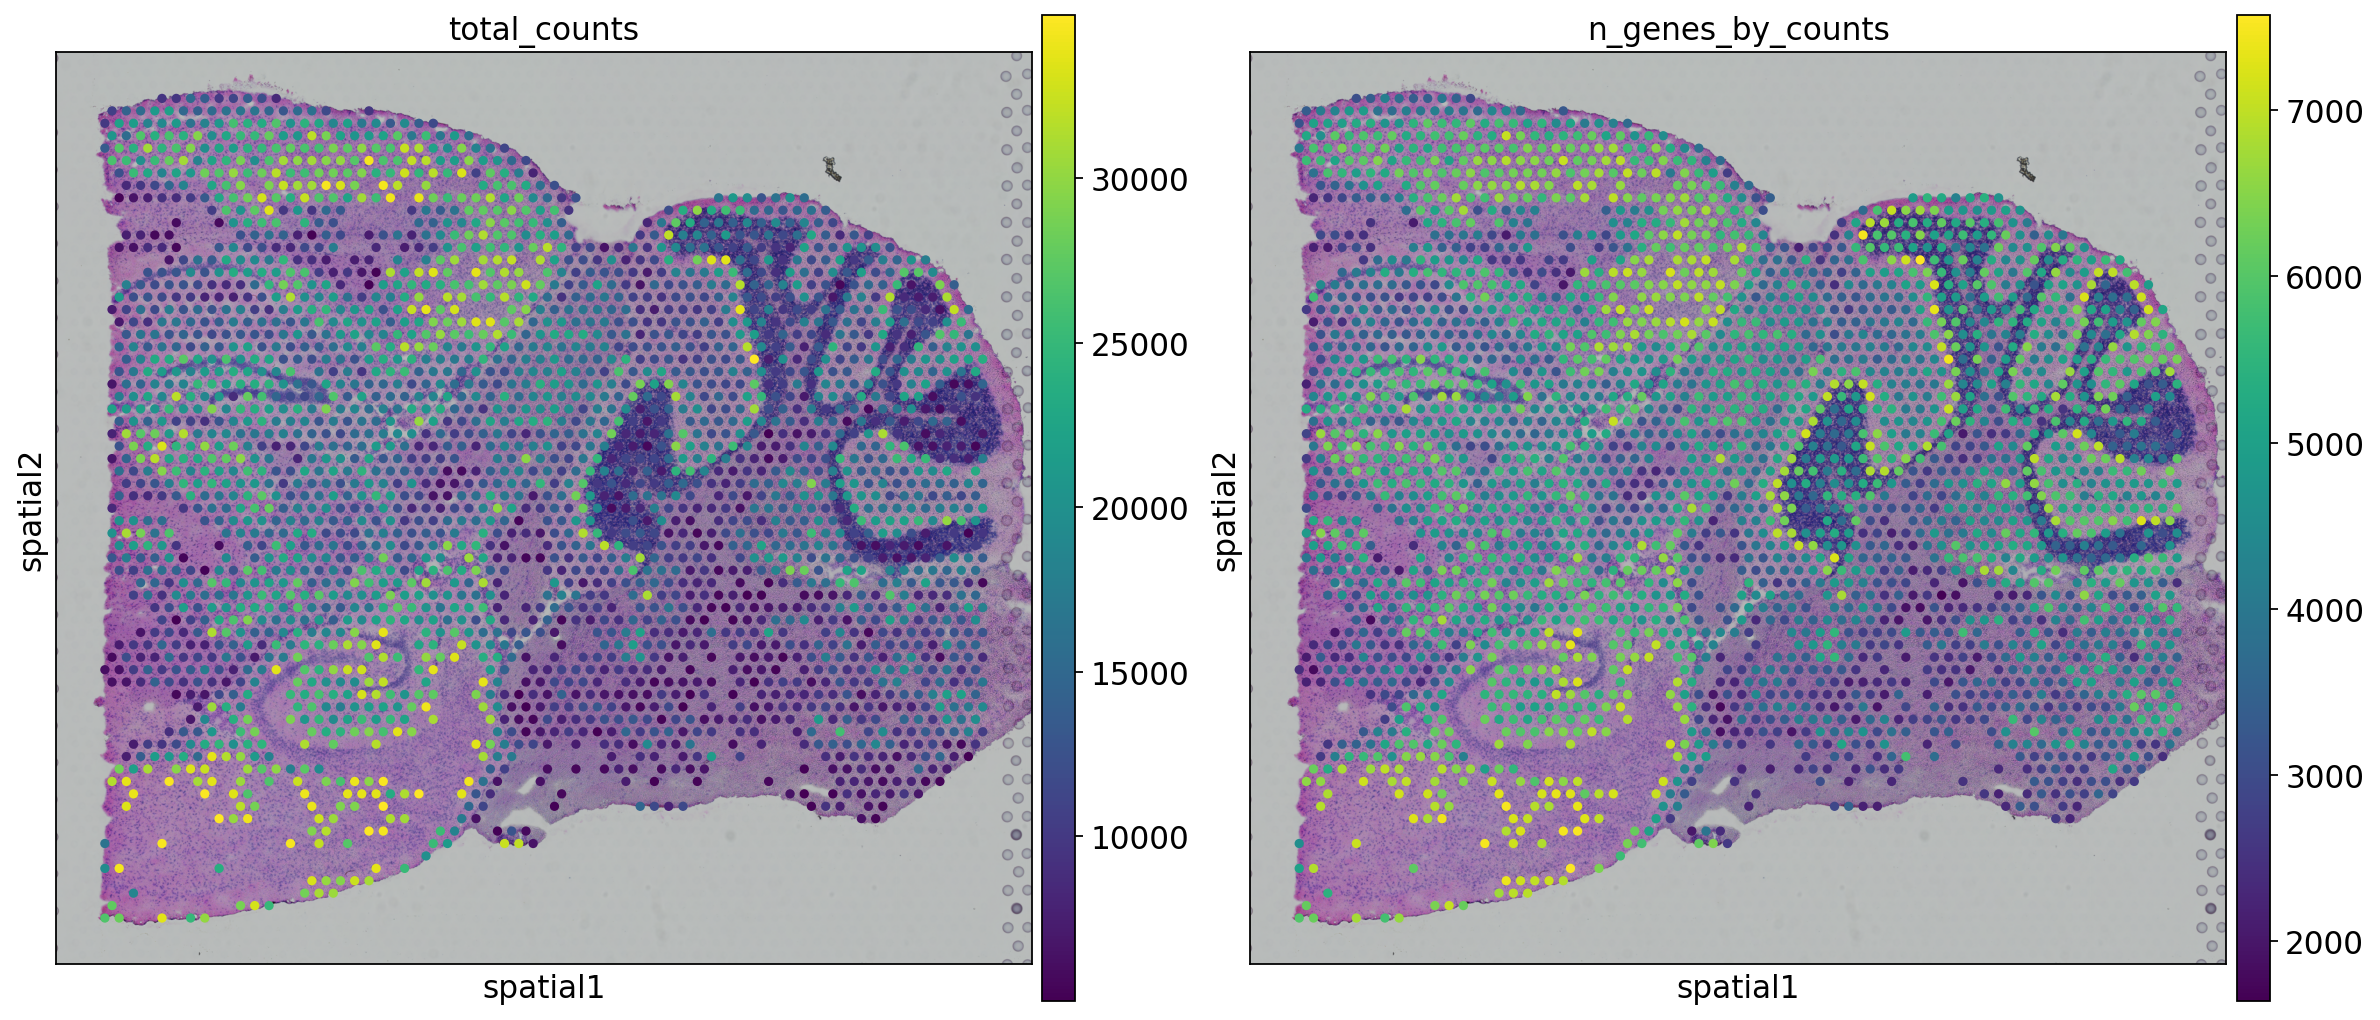

In [19]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

In [20]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters", flavor="igraph", directed=False, n_iterations=2)

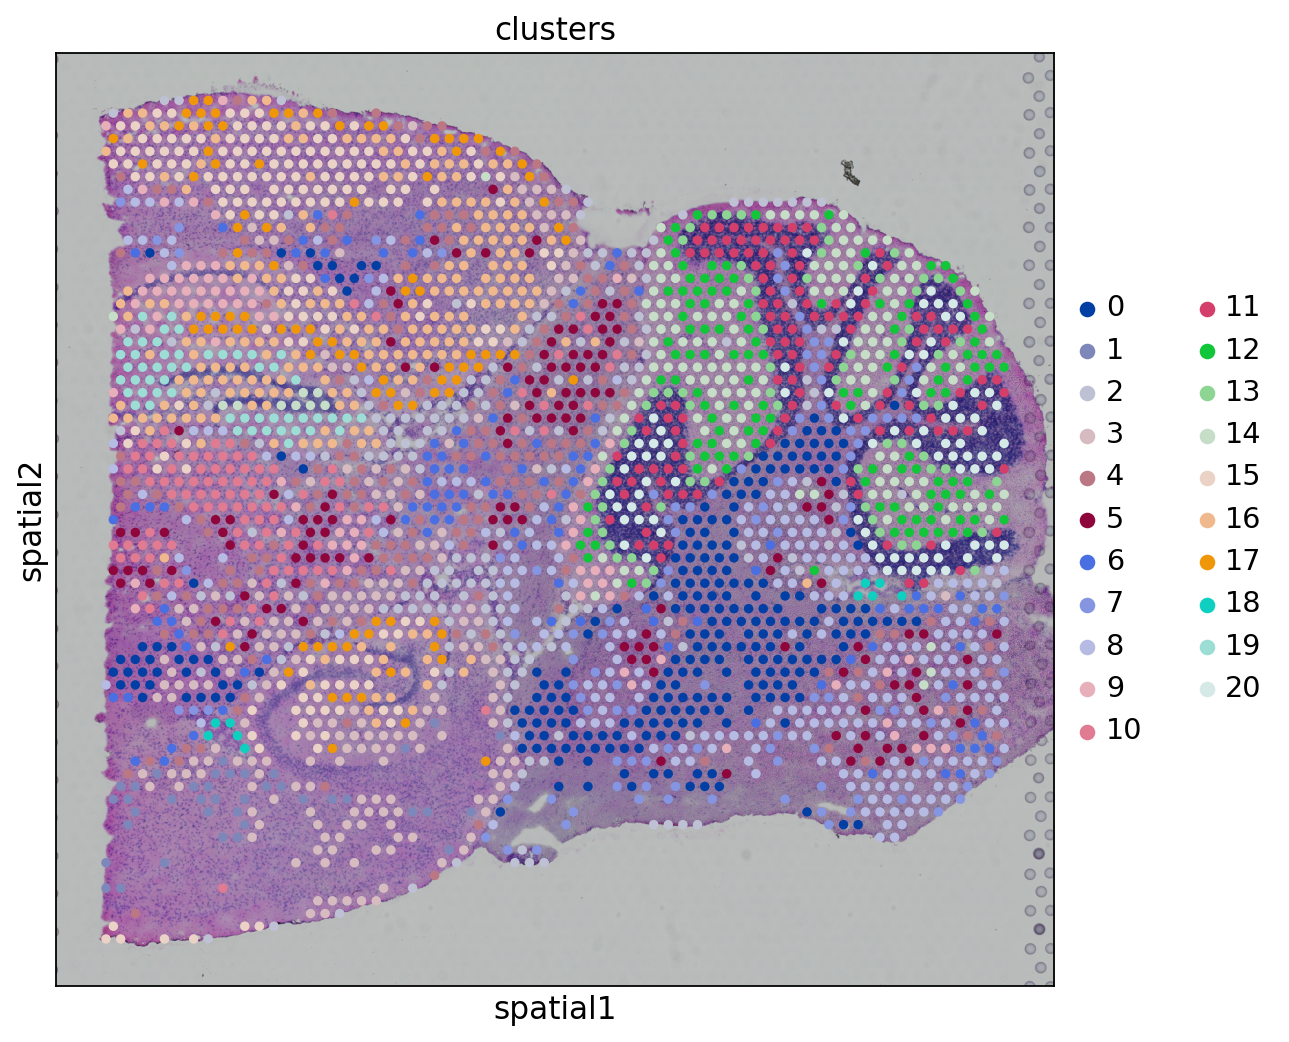

In [21]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["clusters"]) # leiden

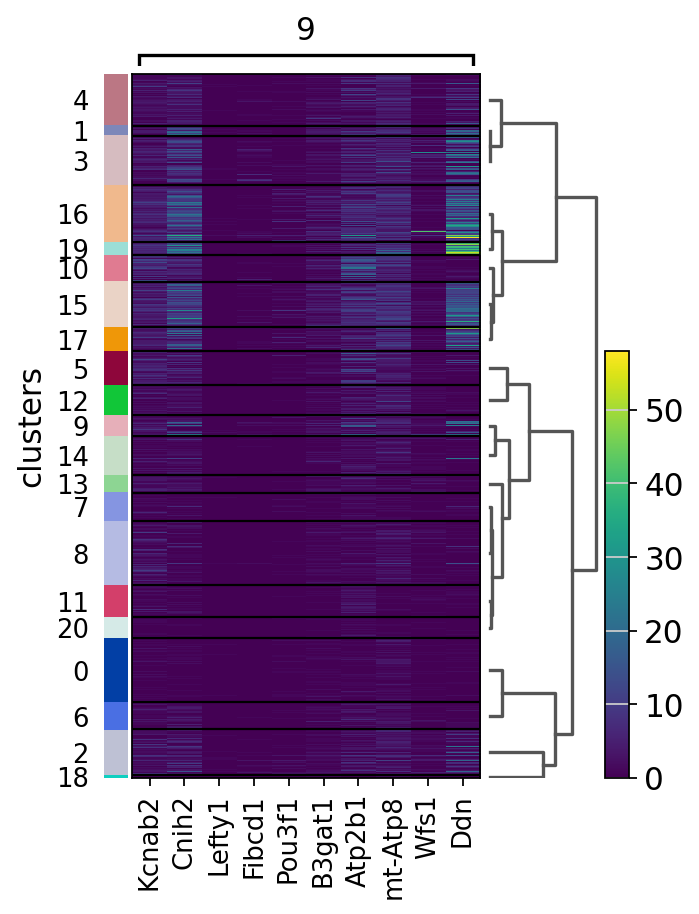

In [22]:
# cluster marker genes
adata.var_names_make_unique()
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="9", n_genes=10, groupby="clusters")

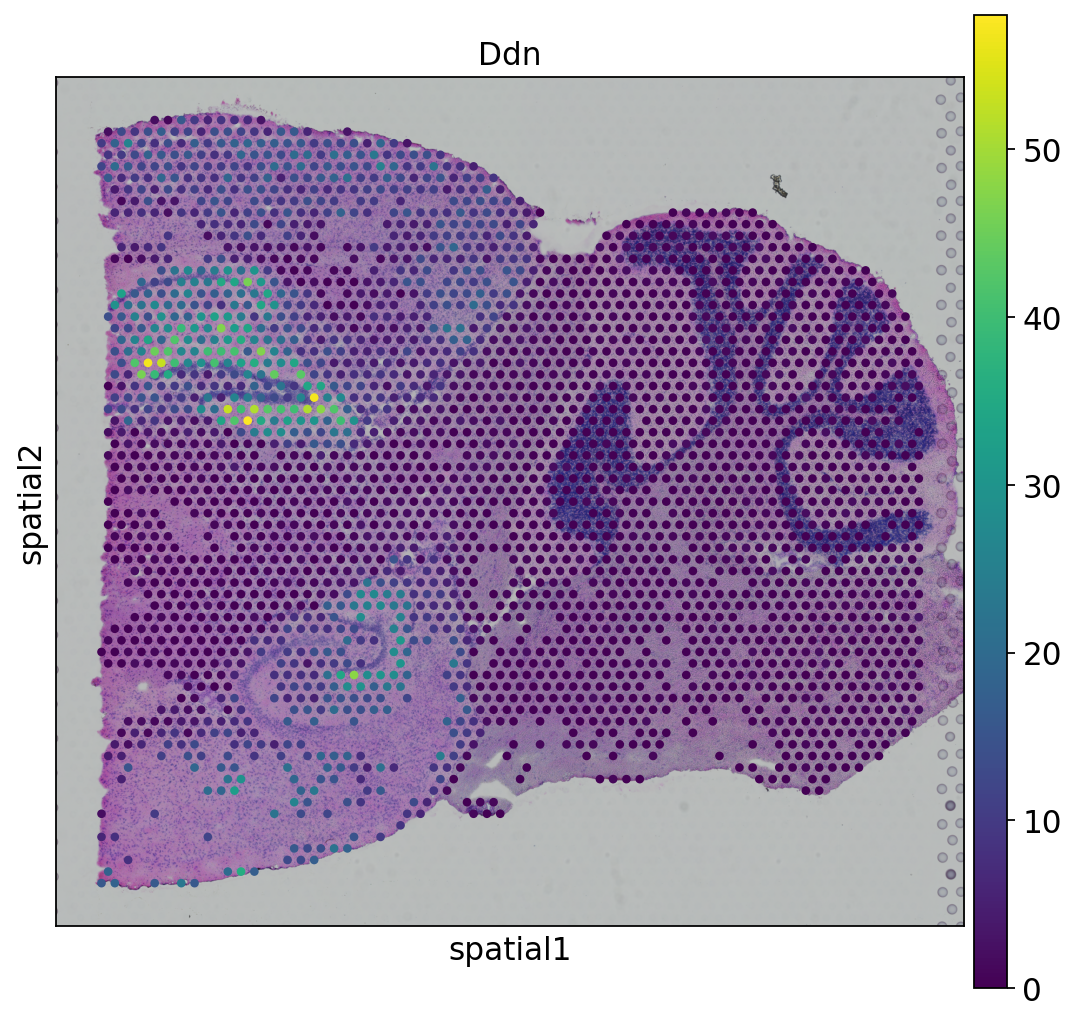

In [23]:
sc.pl.spatial(adata, img_key="hires", color=["Ddn"])

<span style="color: red; font-size: 15px;"> **EX 16: Replicate the analysis in the last section on another 10X Genomics Visium dataset. Check which datasets are available [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.visium_sge.html)**

In [ ]:
# ...